# Diabetes Patients Early Readmissions Prediction

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Frantisek Sefcik](https://github.com/FrantisekSefcik)

## Evaluation

In this jupyter notebook, we evaluate our model for diabetes patients early readmission prediction.

TODO PRECO RF A PRECO UNDERSAMPLED

### Setup and import libraries

In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

# Supress libraries deprecation import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn.metrics import roc_auc_score, auc

from src.preprocessing.helpers import describe_dataset
from src.evaluation import *

### Load train and test data

In [4]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [5]:
describe_dataset(X_train, X_test, y_train, y_test)

Number of train data: 81409
Number of test data: 20353
Number of features: 58
Classes:
	0 :
	    train: 72315 samples, 89.0%
	    test: 18090 samples, 89.0%

	1 :
	    train: 9094 samples, 11.0%
	    test: 2263 samples, 11.0%



#### Data balancing

Random undersampling

In [6]:
X_train, y_train = undersample(X_train, y_train)

In [7]:
len(X_train), len(y_train)

(18188, 18188)

### Feature selection

SKusime:
- RFECV
- len odoberat a sledovat ako crty

- porovnat prve s druhym, ake crty vybralo - best estimator z jedneho top 5 crt a z druheho top 5 crt

- stratified CV kvoli highly unbalanced, 5 folds
    Provides train/test indices to split data in train/test sets.

    This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

#### RFECV

In [8]:
clf = RandomForestClassifier(max_depth=10, random_state=42)

In [9]:
%%time

rfecv = RFECV(clf, step=1, cv=5, scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_train, y_train)

CPU times: user 9.16 s, sys: 86.7 ms, total: 9.24 s
Wall time: 3min 22s


RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=10, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='roc_auc', step=1,
      verbose=0)

Optimal number of features: 55


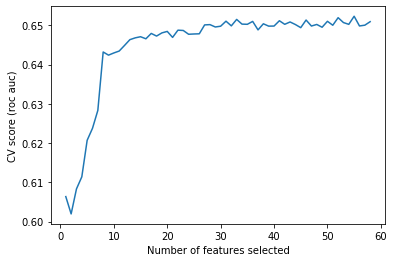

In [10]:
selected_columns = [col for col, selected in zip(X_train.columns, rfecv.support_) if selected]

print(f'Optimal number of features: {rfecv.n_features_}')

plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('CV score (roc auc)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.60      0.73     18090
           1       0.16      0.63      0.26      2263

    accuracy                           0.60     20353
   macro avg       0.55      0.61      0.49     20353
weighted avg       0.84      0.60      0.67     20353

ROC AUC score: 0.61


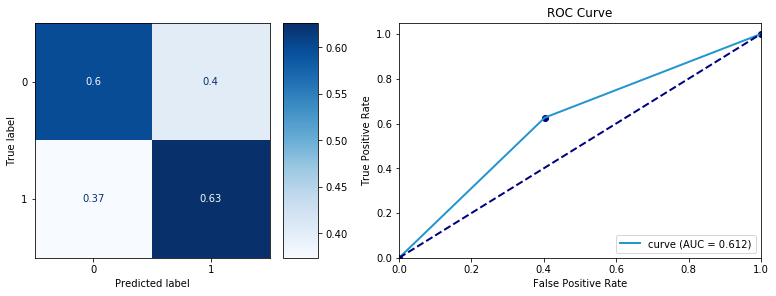

In [11]:
evaluate_model(rfecv.estimator_, X_test[selected_columns], y_test)

In [12]:
set(X_train.columns) - set(selected_columns)

{'age_nan', 'diabetesMed_Yes', 'glyburide_No'}

### Hyperparameter tuning

random search

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 60, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Function to measure the quality of a split
criterion = ['gini', 'entropy']

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 12]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

pprint(random_grid)

In [ ]:
%%time

rs = RandomizedSearchCV(
    estimator=RandomForestClassifier(), param_distributions=random_grid, scoring="roc_auc",
    n_iter = 10, cv=5, random_state=42, n_jobs=-1
)
rs.fit(X_train[selected_columns], y_train)

#### Evaluation

In [ ]:
rs.best_score_

In [ ]:
rs.best_params_

Evaluate best model on test data

In [ ]:
evaluate_model(rs.best_estimator_, X_test[selected_columns], y_test)